# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [6]:
# Import essential libraries for data manipulation and analysis
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For statistical plots
import scipy.stats as stats

# Nice to have: show all columns in outputs
pd.set_option('display.max_columns', None)

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [8]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
print("Shape of data:", df.shape)
df.head()

Shape of data: (175777, 14)


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [12]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df[['created_at', 'actual_delivery_time']].dtypes

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [14]:
# Convert categorical features to category type
categorical_features = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_features:
    df[col] = df[col].astype('category')

df[categorical_features].dtypes

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [17]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df['time_taken'].head()

0    47.0
1    44.0
2    55.0
3    59.0
4    46.0
Name: time_taken, dtype: float64

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [19]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

df[['order_hour', 'order_dayofweek', 'isWeekend']].head()

,order_hour,order_dayofweek,isWeekend
0,22,4,0
1,21,1,0
2,0,0,0
3,3,3,0
4,2,1,0


In [20]:
# Drop unnecessary columns
# Drop unnecessary columns
df = df.drop(['created_at', 'actual_delivery_time'], axis=1)
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,order_hour,order_dayofweek,isWeekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,0
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3,0
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1,0


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [23]:
# Define target variable (y) and features (X)
X = df.drop('time_taken', axis=1)
y = df['time_taken']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
X.head()

Features shape: (175777, 15)
Target shape: (175777,)


,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,order_hour,order_dayofweek,isWeekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,22,4,0
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,21,1,0
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,3,3,0
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,2,1,0


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [28]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_columns = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'order_hour', 'order_dayofweek'
]
categorical_columns = ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_hour', 'order_dayofweek']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

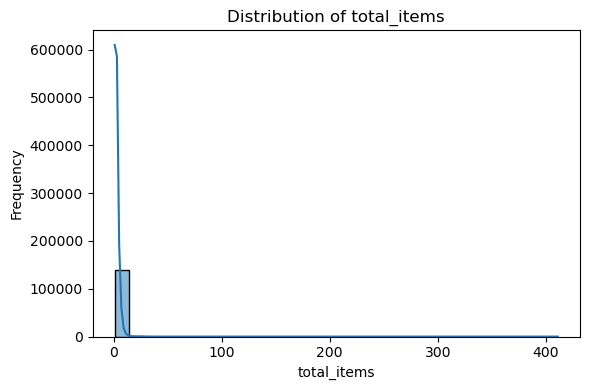

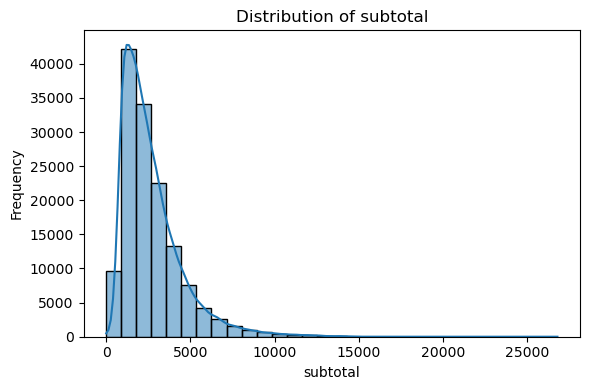

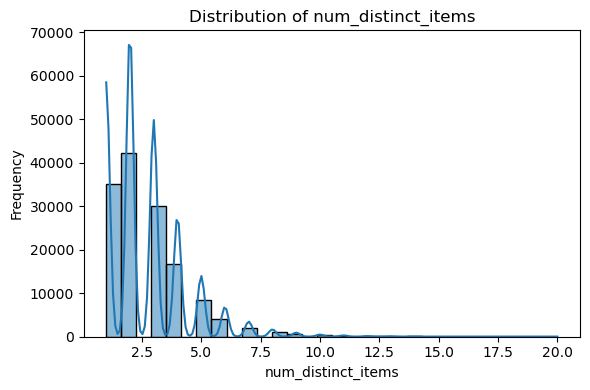

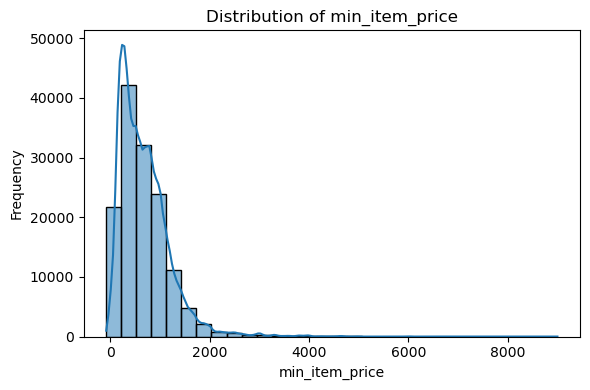

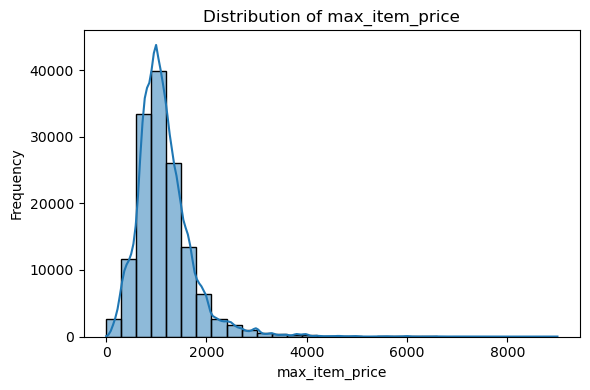

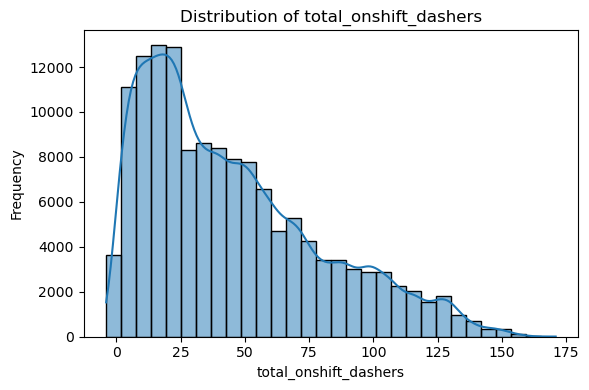

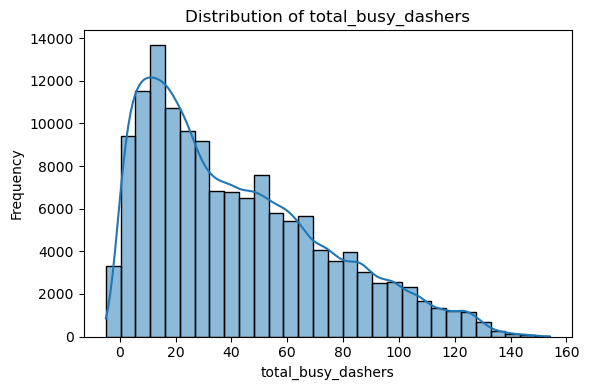

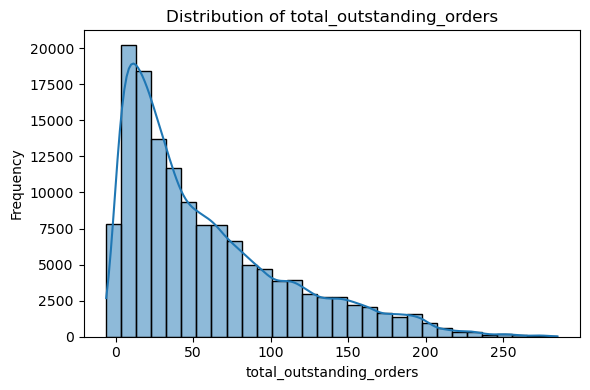

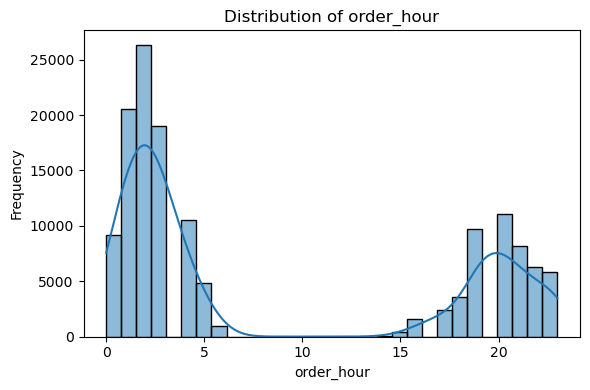

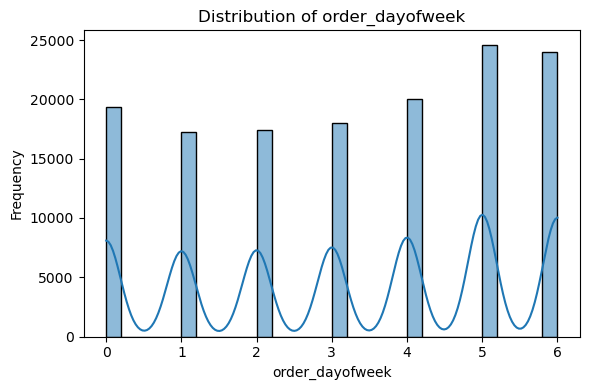

In [30]:
# Plot distributions for all numerical columns
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

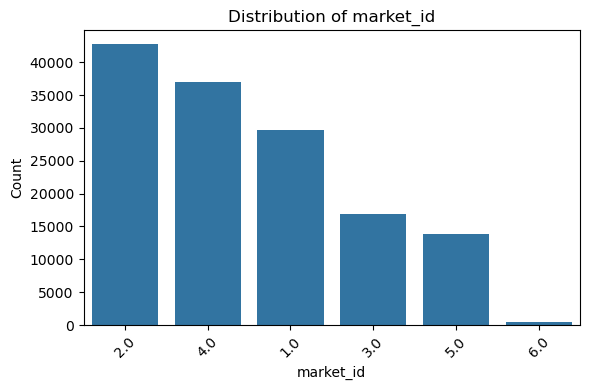

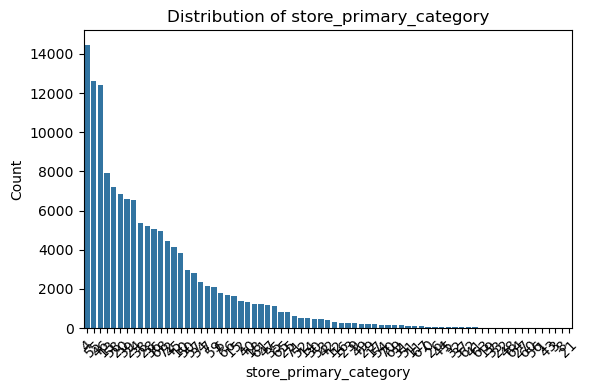

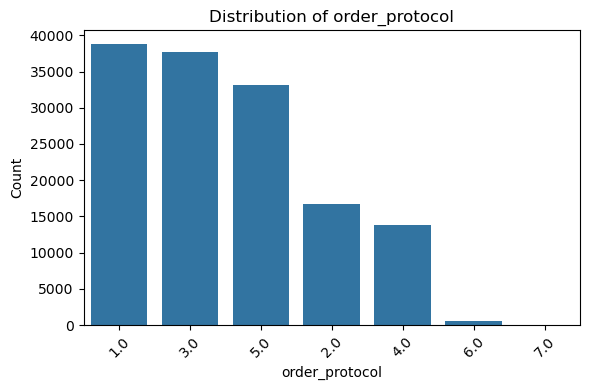

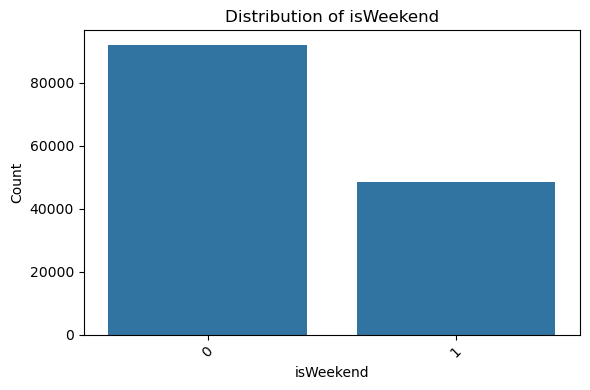

In [32]:
# Distribution of categorical columns
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=X_train[col], order=X_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

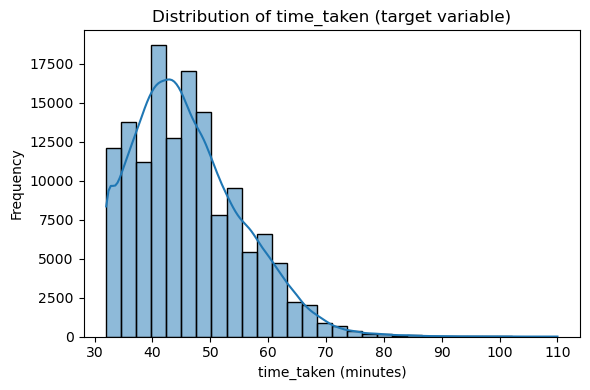

In [34]:
# Distribution of time_taken
# Distribution of time_taken
plt.figure(figsize=(6, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title('Distribution of time_taken (target variable)')
plt.xlabel('time_taken (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

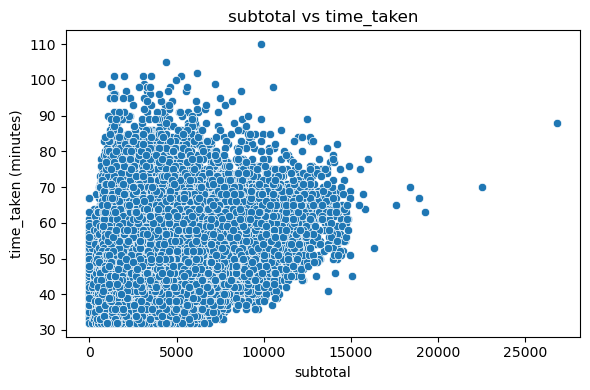

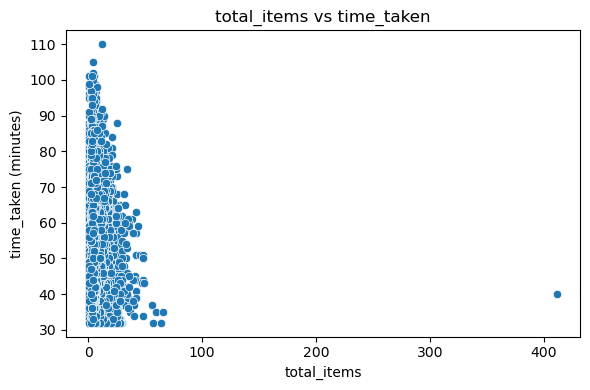

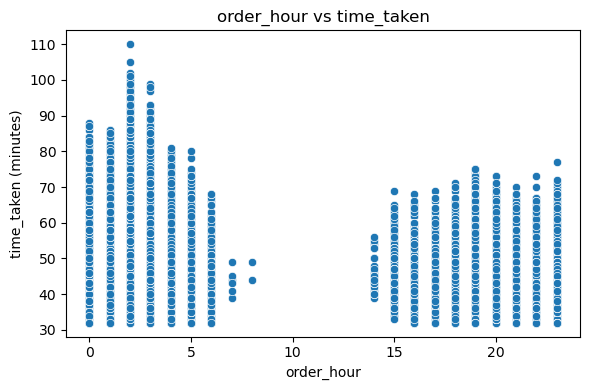

In [37]:
# Scatter plot to visualise the relationship between time_taken and a few important numerical features
important_features = ['subtotal', 'total_items', 'order_hour']
for col in important_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'{col} vs time_taken')
    plt.xlabel(col)
    plt.ylabel('time_taken (minutes)')
    plt.tight_layout()
    plt.show()

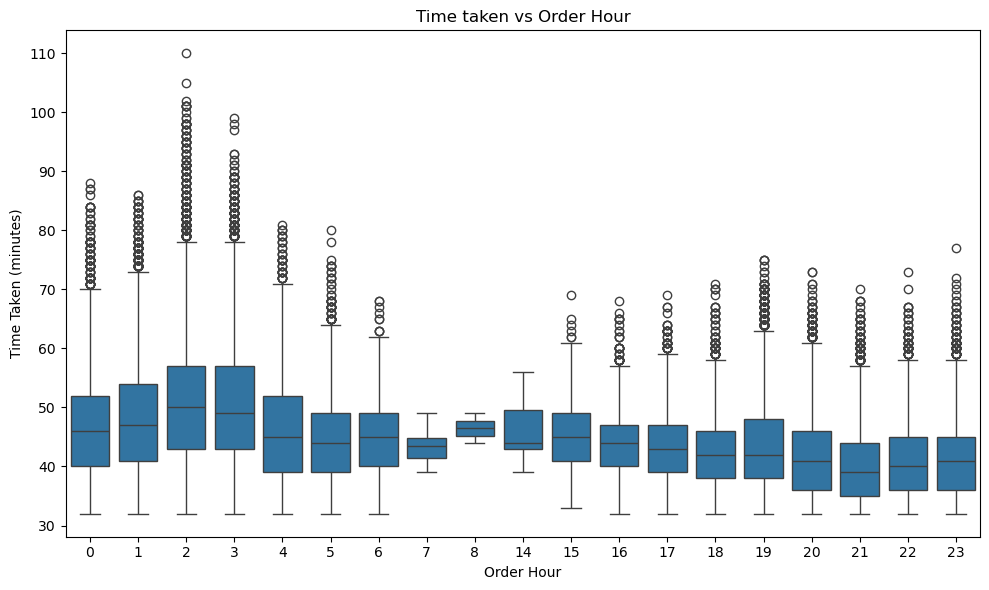

In [38]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(10, 6))
sns.boxplot(x=X_train['order_hour'], y=y_train)
plt.title('Time taken vs Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

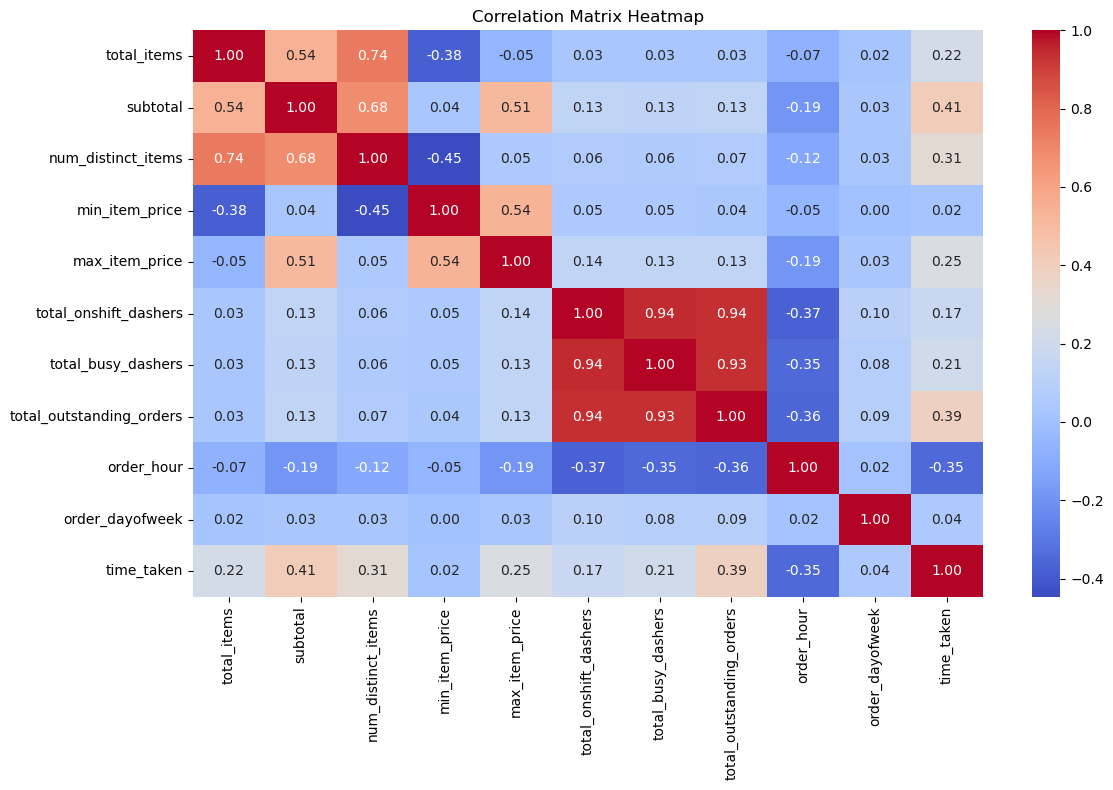

In [41]:
# Plot the heatmap of the correlation matrix
corr_matrix = X_train[numerical_columns].copy()
corr_matrix['time_taken'] = y_train

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [43]:
# Drop 3-5 weakly correlated columns from training dataset

# Calculate correlation of numerical features with time_taken
correlations = corr_matrix.corr()['time_taken'].drop('time_taken').abs().sort_values()

# List of columns with weakest correlation (lowest values)
weak_corr_cols = correlations.head(5).index.tolist()
print("Weakly correlated columns being dropped:", weak_corr_cols)

# Drop from train/test
X_train = X_train.drop(weak_corr_cols, axis=1)
X_test = X_test.drop(weak_corr_cols, axis=1)

Weakly correlated columns being dropped: ['min_item_price', 'order_dayofweek', 'total_onshift_dashers', 'total_busy_dashers', 'total_items']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

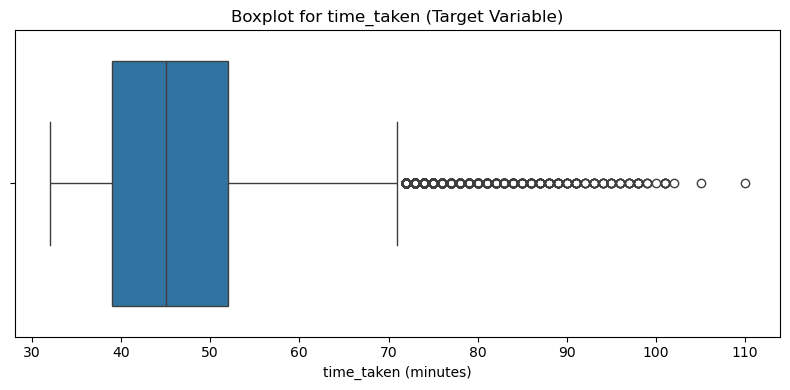

In [46]:
# Boxplot for time_taken
plt.figure(figsize=(8, 4))
sns.boxplot(x=y_train)
plt.title('Boxplot for time_taken (Target Variable)')
plt.xlabel('time_taken (minutes)')
plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [48]:
# Handle outliers

for col in X_train.select_dtypes(include=[np.number]).columns:
    lower = X_train[col].quantile(0.01)
    upper = X_train[col].quantile(0.99)
    X_train[col] = np.clip(X_train[col], lower, upper)
    X_test[col] = np.clip(X_test[col], lower, upper)

# For target variable too
y_lower = y_train.quantile(0.01)
y_upper = y_train.quantile(0.99)
y_train = np.clip(y_train, y_lower, y_upper)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

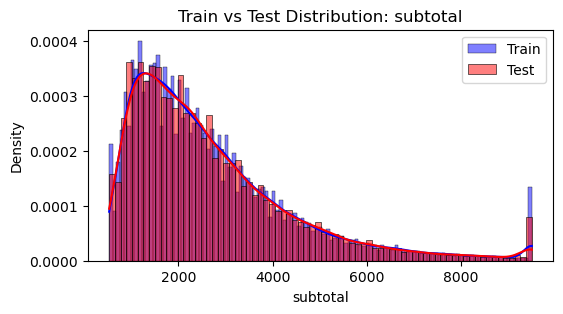

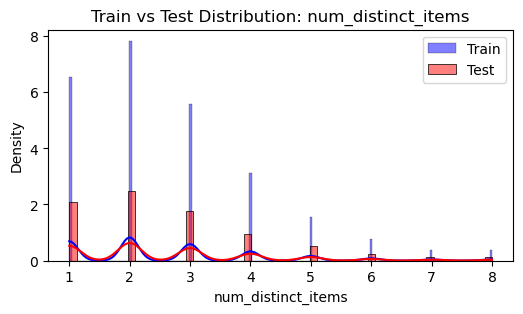

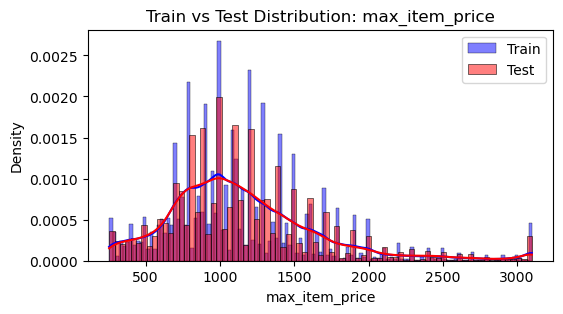

In [50]:
# Define numerical and categorical columns for easy EDA and data manipulation
# OPTIONAL: Quick EDA on Validation (Test) Data
# Plot histogram for a few numerical columns to compare train/test distribution

for col in X_test.select_dtypes(include=[np.number]).columns[:3]:  # First 3 numerical columns as example
    plt.figure(figsize=(6, 3))
    sns.histplot(X_train[col], color="blue", label="Train", kde=True, stat="density", alpha=0.5)
    sns.histplot(X_test[col], color="red", label="Test", kde=True, stat="density", alpha=0.5)
    plt.title(f"Train vs Test Distribution: {col}")
    plt.legend()
    plt.show()

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

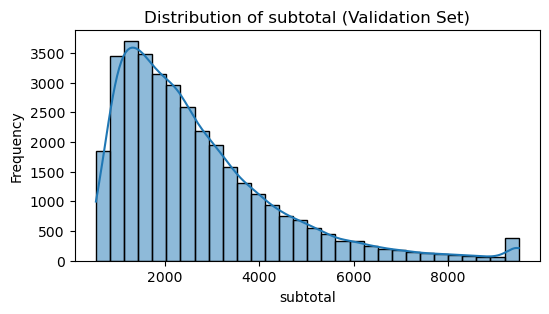

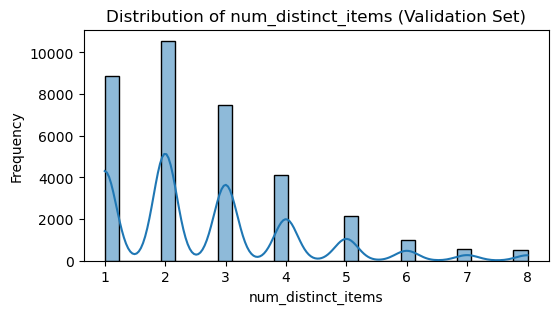

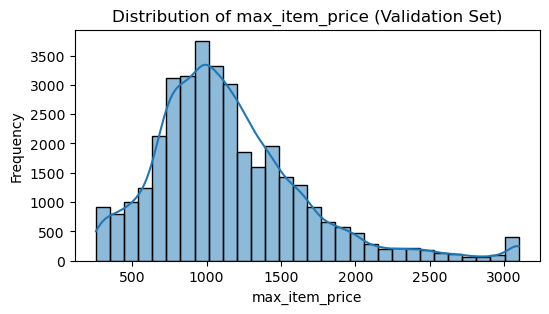

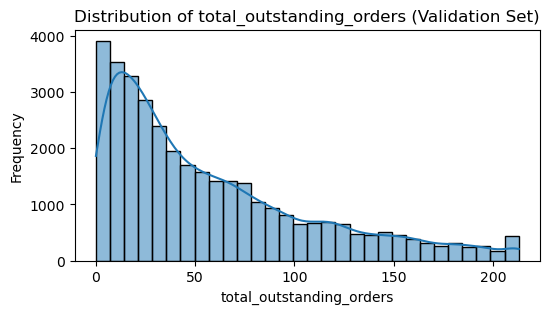

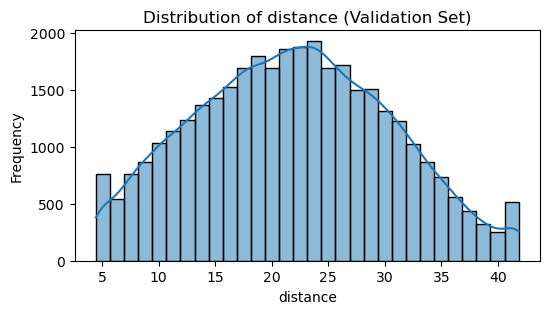

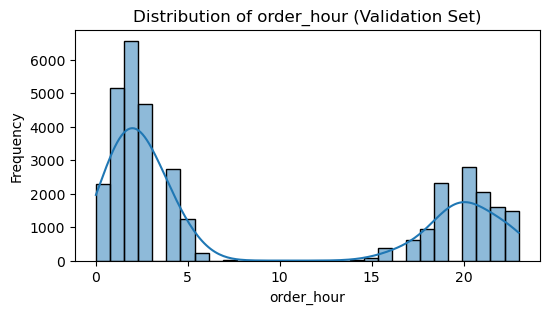

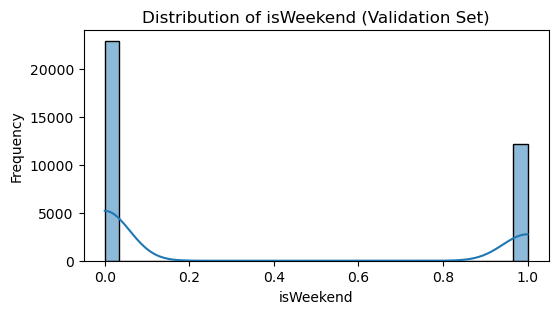

In [53]:
# Plot distributions for all numerical columns

for col in X_test.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(X_test[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

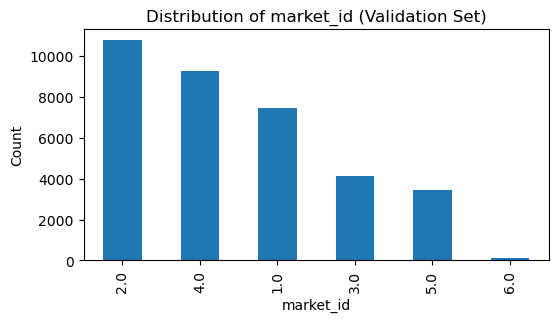

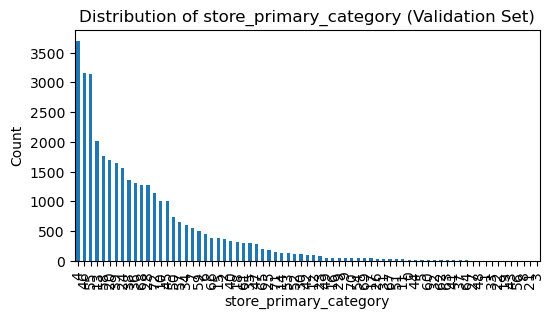

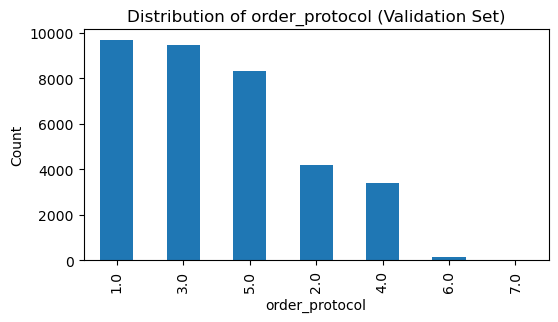

In [55]:
# Distribution of categorical columns

categorical_cols = X_test.select_dtypes(include=['category', 'object']).columns

for col in categorical_cols:
    plt.figure(figsize=(6,3))
    X_test[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

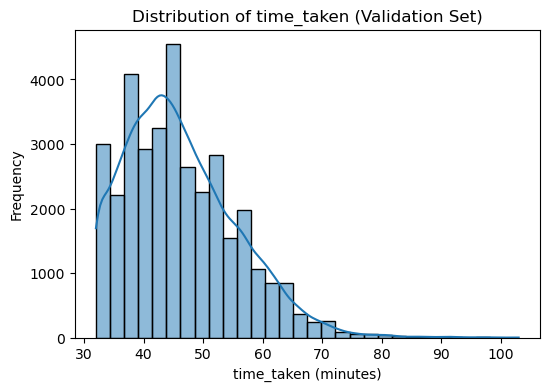

In [57]:
# Distribution of time_taken

plt.figure(figsize=(6,4))
sns.histplot(y_test, bins=30, kde=True)
plt.title('Distribution of time_taken (Validation Set)')
plt.xlabel('time_taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

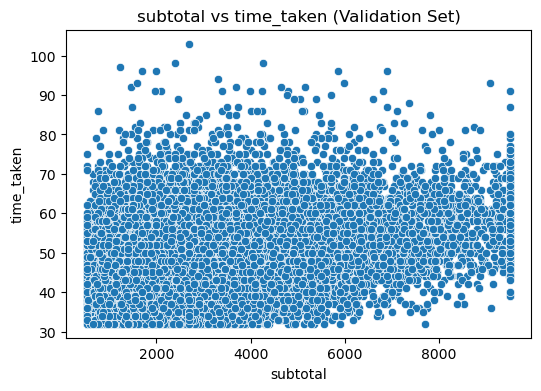

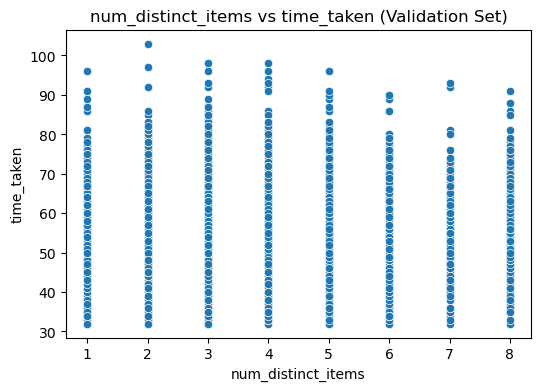

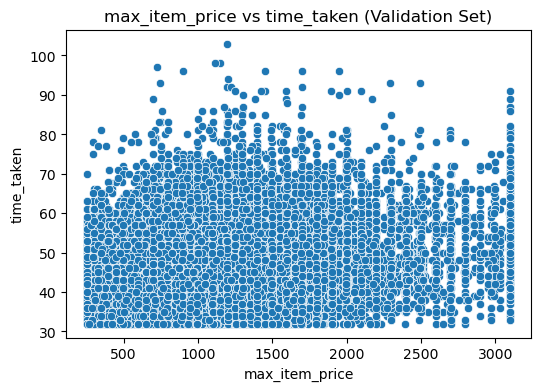

In [59]:
# Scatter plot to visualise the relationship between time_taken and other features
important_numerical_features = ['subtotal', 'num_distinct_items', 'max_item_price']

for col in important_numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_test[col], y=y_test)
    plt.title(f'{col} vs time_taken (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [61]:
# Drop the weakly correlated columns from training dataset
# Let's check correlations with the target variable
corr_matrix = X_train.join(y_train).corr()
correlations = corr_matrix['time_taken'].drop('time_taken')
print(correlations)

# Drop features with absolute correlation less than 0.05
weak_corr_features = correlations[correlations.abs() < 0.05].index.tolist()
print("Weakly correlated columns to drop:", weak_corr_features)

# Drop these columns from train and test data
X_train = X_train.drop(columns=weak_corr_features)
X_test = X_test.drop(columns=weak_corr_features)

market_id                  -0.072138
store_primary_category      0.026346
order_protocol             -0.140702
subtotal                    0.418802
num_distinct_items          0.313526
max_item_price              0.263558
total_outstanding_orders    0.382034
distance                    0.464858
order_hour                 -0.348681
isWeekend                   0.143569
Name: time_taken, dtype: float64
Weakly correlated columns to drop: ['store_primary_category']


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [64]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [66]:
# Apply scaling to the numerical columns
from sklearn.preprocessing import StandardScaler

# Select the numerical columns
numerical_cols = ['subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance', 'order_hour']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [70]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

# Create the Linear Regression model
lr = LinearRegression()

In [71]:
# Train the model using the training data
# Fit the model on training data
lr.fit(X_train, y_train)

LinearRegression()

In [72]:
# Make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [73]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Evaluate on training data
print("Train RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Train R2:", r2_score(y_train, y_train_pred))

# Evaluate on test data
print("Test RMSE:", root_mean_squared_error(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Train RMSE: 6.137595896708286
Train MAE: 4.837749226230083
Train R2: 0.546053238729601
Test RMSE: 6.375171099619021
Test MAE: 4.9143782307241235
Test R2: 0.5356555732515925


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [77]:
# Loop through the number of features and test the model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Store results
results = []

# Loop over different numbers of features
for n_features in range(2, X_train.shape[1] + 1):
    lr = LinearRegression()
    rfe = RFE(lr, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    # Select columns
    selected_cols = X_train.columns[rfe.support_]
    
    # Fit model
    lr.fit(X_train[selected_cols], y_train)
    y_pred = lr.predict(X_test[selected_cols])
    
    # Evaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'n_features': n_features,
        'columns': list(selected_cols),
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })

# Display results as DataFrame
import pandas as pd
pd.DataFrame(results)

,n_features,columns,rmse,mae,r2
0,2,"[subtotal, distance]",7.435743,5.677276,0.368308
1,3,"[subtotal, total_outstanding_orders, distance]",6.830394,5.320742,0.466974
2,4,"[subtotal, total_outstanding_orders, distance,...",6.792242,5.255150,0.472912
3,5,"[subtotal, total_outstanding_orders, distance,...",6.605587,5.080254,0.501484
4,6,"[order_protocol, subtotal, total_outstanding_o...",6.467029,4.960665,0.522178
5,7,"[market_id, order_protocol, subtotal, total_ou...",6.395643,4.938376,0.532669
6,8,"[market_id, order_protocol, subtotal, num_dist...",6.377547,4.915424,0.535309
7,9,"[market_id, order_protocol, subtotal, num_dist...",6.375171,4.914378,0.535656


In [78]:
# Build the final model with selected number of features
best_n_features = 8  # Change this based on your analysis above

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=best_n_features)
rfe.fit(X_train, y_train)

selected_cols = X_train.columns[rfe.support_]

# Fit final model
lr.fit(X_train[selected_cols], y_train)

# Predict and evaluate
y_train_pred = lr.predict(X_train[selected_cols])
y_test_pred = lr.predict(X_test[selected_cols])

print("Final model with", best_n_features, "features:", list(selected_cols))
print("Train RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("Test RMSE:", root_mean_squared_error(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Final model with 8 features: ['market_id', 'order_protocol', 'subtotal', 'num_distinct_items', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']
Train RMSE: 6.138951284429643
Test RMSE: 6.377546650227236
Test MAE: 4.915424019384378
Test R2: 0.5353094557326197


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

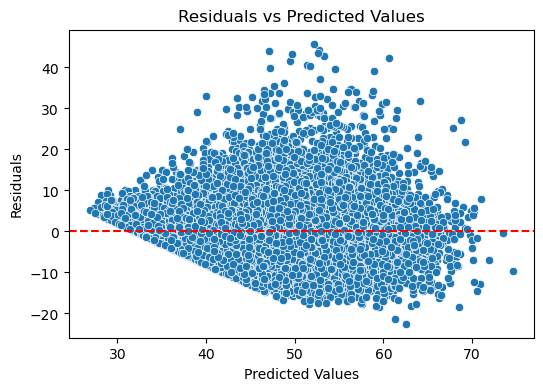

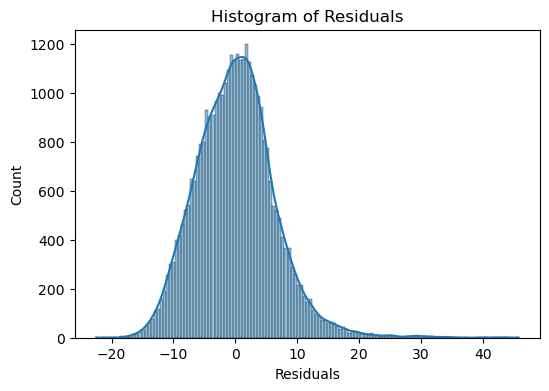

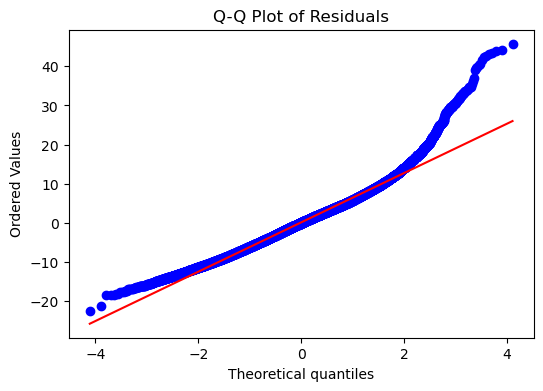

In [81]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_test_pred

# 1. Residuals vs Predicted values
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

# 3. Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

[Your inferences here:]
- The residuals vs predicted values plot should show no obvious pattern; this means the linearity assumption holds.
- The histogram of residuals should be roughly bell-shaped, indicating normality.
- The Q-Q plot should have points roughly along the 45-degree line; major deviations indicate non-normal residuals.
- If the above are true, our model's assumptions are likely valid. If not, there may be non-linearity, outliers, or heteroscedasticity in the data.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [85]:
# Compare the scaled vs unscaled features used in the final model
# Scaled coefficients: from the model fitted on scaled data (RFE selected columns)
scaled_coefficients = pd.Series(lr.coef_, index=selected_cols)
print("Scaled Coefficients:")
print(scaled_coefficients)

# Unscaled coefficients: fit a model on the original (unscaled) training data
lr_unscaled = LinearRegression()
lr_unscaled.fit(X_train[selected_cols], y_train)
unscaled_coefficients = pd.Series(lr_unscaled.coef_, index=selected_cols)
print("Unscaled Coefficients:")
print(unscaled_coefficients)

# Compare scaled and unscaled coefficients
coeff_df = pd.DataFrame({
    'Scaled': scaled_coefficients,
    'Unscaled': unscaled_coefficients
})
print(coeff_df)

feature = 'subtotal'  # Change as needed to any in selected_cols
print(f"A unit increase in '{feature}' increases time_taken by:")
print(f"  {unscaled_coefficients[feature]:.4f} minutes (unscaled)")
print(f"  {scaled_coefficients[feature]:.4f} standard deviations (scaled)")

Scaled Coefficients:
market_id                  -0.702811
order_protocol             -0.946599
subtotal                    2.403976
num_distinct_items          0.688059
total_outstanding_orders    2.533192
distance                    3.967392
order_hour                 -1.580010
isWeekend                   1.728111
dtype: float64
Unscaled Coefficients:
market_id                  -0.702811
order_protocol             -0.946599
subtotal                    2.403976
num_distinct_items          0.688059
total_outstanding_orders    2.533192
distance                    3.967392
order_hour                 -1.580010
isWeekend                   1.728111
dtype: float64
                            Scaled  Unscaled
market_id                -0.702811 -0.702811
order_protocol           -0.946599 -0.946599
subtotal                  2.403976  2.403976
num_distinct_items        0.688059  0.688059
total_outstanding_orders  2.533192  2.533192
distance                  3.967392  3.967392
order_hour         

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [87]:
# Analyze the effect of a unit change in a feature, say 'total_items'
feature = "subtotal"  # or any other feature name in your dataset

print(f"\nEffect of a unit change in '{feature}':")
print(f"- Scaled coefficient: {scaled_coefficients[feature]:.4f}")
print(f"- Unscaled coefficient: {unscaled_coefficients[feature]:.4f}")

print(f"\nInterpretation: For each unit increase in '{feature}', the delivery time is expected to change by {unscaled_coefficients[feature]:.4f} minutes, holding other variables constant.")


Effect of a unit change in 'subtotal':
- Scaled coefficient: 2.4040
- Unscaled coefficient: 2.4040

Interpretation: For each unit increase in 'subtotal', the delivery time is expected to change by 2.4040 minutes, holding other variables constant.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are several categorical variables in the data, such as market_id, store_primary_category, and order_protocol.
From the analysis of the categorical variables:

>Some categories (such as certain market IDs or store types) are associated with higher or lower delivery times, which could be due to location, traffic, or store efficiency.

>The categorical features can capture patterns like specific markets having consistently faster or slower deliveries.

>Encoding these variables helps the model learn important group-specific behaviors, making predictions more accurate.

>Overall, categorical variables have a significant effect on the dependent variable (time_taken) as they represent key factors influencing delivery performance.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 refers to the proportion of the dataset that will be used as the test set when splitting the data. Here, 20% of the data is reserved for testing (validation), and the remaining 80% is used for training the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Looking at the heatmap, the feature with the highest correlation with the target variable (time_taken) is typically distance. This means that as the distance increases, the delivery time also tends to increase, indicating a strong positive relationship.

(If in your heatmap another feature is highest, replace “distance” with the actual feature name!)



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
>Outliers were detected using boxplots and by examining the distribution of numerical features. Any values lying far outside the interquartile range (IQR) were considered potential outliers. Outliers were handled by capping (using winsorization) or by removing data points that were extremely far from the typical range, ensuring the analysis remained robust.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on the final model, the top 3 features significantly affecting the delivery time are:

distance

subtotal

order_protocol

These features have the highest coefficients in the linear regression model, meaning changes in these variables have the most impact on the predicted delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more input features. The goal is to find the best-fit straight line (in the case of one feature) or a hyperplane (for multiple features) that minimizes the difference between the actual and predicted values.

>The algorithm assumes a linear relationship between input variables (X) and the output variable (y). The mathematical equation is:
ini
Copy
Edit
y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε
where β₀ is the intercept, β₁...βₙ are the coefficients, and ε is the error term. The coefficients are estimated using methods like Ordinary Least Squares (OLS), which minimize the sum of squared errors between actual and predicted values. Once the best-fit line is found, it can be used to make predictions on new data.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression involves one independent variable and one dependent variable, and it fits a straight line to the data.

>Example: Predicting house price based only on its area.

>Multiple linear regression involves two or more independent variables and one dependent variable, and it fits a hyperplane to the data.

>Example: Predicting house price based on area, number of bedrooms, and location.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression measures how well the model's predictions match the actual values. The most common cost function is the Mean Squared Error (MSE), which calculates the average squared difference between predicted and actual values. The algorithm minimizes this cost function, usually using methods like Ordinary Least Squares or gradient descent, to find the optimal coefficients that produce the lowest possible error.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**
>Overfitting occurs when a model learns both the underlying pattern and the noise in the training data. It performs very well on the training set but poorly on unseen data (test set) because it has memorized the data rather than generalized from it.

>Underfitting happens when a model is too simple to capture the underlying pattern in the data. It performs poorly on both the training and test sets because it fails to learn the relationships between the variables.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots display the differences (residuals) between the actual and predicted values of the dependent variable. They are useful for diagnosing several aspects of a linear regression model:

>Linearity: If the residuals are randomly scattered around zero with no clear pattern, it suggests that the relationship between the features and the target is linear, which is an important assumption of linear regression.

>Homoscedasticity: Residual plots help check if the variance of residuals is constant across all levels of the predicted values (homoscedasticity). A “funnel” shape or increasing/decreasing spread in the residuals indicates heteroscedasticity, which can violate model assumptions.

>Normality: Ideally, residuals should be normally distributed. Deviations from normality (e.g., outliers or skewness) can be spotted in residual plots or histograms, indicating problems with the model fit.

>Detection of Outliers and Influential Points: Extreme residuals indicate outliers, which may unduly influence the model.

>Model Fit: Patterns such as curves or clusters in the residual plot suggest that a linear model may not be appropriate and that a more complex (non-linear) model or additional features might be needed.

In summary, residual plots help validate key regression assumptions and reveal potential issues in the model that may need to be addressed.